In [ ]:
TEST_DATE = "2024-07-08"
TEST_FOLDER = "test2"
TEMP_FILE = "temp2.nc"
WIND_FILE = "windspeed2.nc"
PRECIP_FILE = "precipitation2.nc"

# CLLMate: Multimodal LLM for Weather and Climate Events Forecasting
## Complete Implementation and Analysis

## 1. Overview and Architecture {#overview}

### Current Implementation Status
Current implementation includes:

✅ **Data preprocessing and RGB conversion**  
✅ **CLIP feature extraction**  
✅ **Enhanced pattern detection (SCAFET-inspired)**  
✅ **Visual feature analysis**  

---

## 2. Data Processing Pipeline {#data-processing}

### 2.1 RGB Image Generation

In [ ]:
# From rgb_image_script.py
import xarray as xr
import numpy as np
from PIL import Image
import datetime
import os

# Load datasets
temp_ds = xr.open_dataset(TEMP_FILE)
precip_ds = xr.open_dataset(PRECIP_FILE)
wind_ds = xr.open_dataset(WIND_FILE)

# Extract variable names
temp_var = "T2M"
precip_var = "PRECTOTCORR"
wind_var = "WS10M"

# Function to normalize data to 0–255 (following CLLMate methodology)
def normalize(data):
    """
    Normalize meteorological data following CLLMate paper specifications
    """
    arr = data.values
    arr = np.nan_to_num(arr, nan=0.0)
    min_val, max_val = np.percentile(arr, 2), np.percentile(arr, 98)
    norm = (arr - min_val) / (max_val - min_val)
    norm = np.clip(norm, 0, 1)
    return (norm * 255).astype(np.uint8)

# Process daily data for entire year
def create_daily_rgb_images():
    """Generate RGB images for each day following CLLMate format"""
    # os.makedirs("rgb_images", exist_ok=True)
    test_folder = TEST_FOLDER
    os.makedirs(f"{test_folder}/rgb_images", exist_ok=True)
    start_date = datetime.date(2024, 1, 1)
    end_date = datetime.date(2024, 12, 31)
    delta = datetime.timedelta(days=1)
    
    current_date = start_date
    processed_count = 0
    
    while current_date <= end_date:
        date_str = current_date.isoformat()
        try:
            date_np = np.datetime64(current_date)
            
            # Extract meteorological data for the date
            temp_data = temp_ds[temp_var].sel(time=date_np, method="nearest")
            precip_data = precip_ds[precip_var].sel(time=date_np, method="nearest")
            wind_data = wind_ds[wind_var].sel(time=date_np, method="nearest")
            
            # Create RGB channels (T=Red, W=Green, P=Blue)
            R = normalize(temp_data)  # Temperature → Red
            G = normalize(wind_data)  # Wind Speed → Green  
            B = normalize(precip_data) # Precipitation → Blue
            
            # Stack into RGB image
            rgb_image = np.stack([R, G, B], axis=-1)
            img = Image.fromarray(rgb_image)
            img.save(f"{test_folder}/rgb_images/rgb_image_{date_str}.png")       
            print(f"Saved: {test_folder}/rgb_images/rgb_image_{date_str}.png")      
            processed_count += 1
            if processed_count % 30 == 0:
                print(f"Processed {processed_count} days...")
                
        except Exception as e:
            print(f"Skipped {date_str}: {e}")
        
        current_date += delta
    
    print(f"Total processed: {processed_count} RGB images")

# Execute RGB generation
create_daily_rgb_images()

### 2.2 Data Statistics and Context Generation

In [ ]:
def generate_meteorological_context(date_str):
    """
    Generate statistical context following CLLMate paper format
    """
    date_np = np.datetime64(date_str)
    
    # Extract raw data
    temp_data = temp_ds[temp_var].sel(time=date_np, method="nearest").values
    precip_data = precip_ds[precip_var].sel(time=date_np, method="nearest").values
    wind_data = wind_ds[wind_var].sel(time=date_np, method="nearest").values
    
    # Calculate statistics
    stats = {
        'max_temp': float(np.nanmax(temp_data)),
        'min_temp': float(np.nanmin(temp_data)),
        'mean_temp': float(np.nanmean(temp_data)),
        'max_wind': float(np.nanmax(wind_data)),
        'min_wind': float(np.nanmin(wind_data)),
        'mean_wind': float(np.nanmean(wind_data)),
        'max_precip': float(np.nanmax(precip_data)),
        'min_precip': float(np.nanmin(precip_data)),
        'mean_precip': float(np.nanmean(precip_data))
    }
    
    return stats

# Example usage
example_stats = generate_meteorological_context(TEST_DATE)
print("Meteorological Context Example:")
for key, value in example_stats.items():
    print(f"  {key}: {value:.2f}")

### 2.3 Geographic Visualization

In [ ]:
# Add this as Section 2.3 - Geographic Visualization
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def create_coordinate_visualization(date_str, test_folder, bbox=None):
    """
    Create world map showing the data coverage area
    """
    # Default bounding box (adjust based on your NetCDF data coverage)
    if bbox is None:
        # Example coordinates - adjust these to match your actual data
        bbox = {
            'lon_min': 65.5,   # Western boundary
            'lon_max': 137.0,  # Eastern boundary  
            'lat_min': 16.5,   # Southern boundary
            'lat_max': 55.5    # Northern boundary
        }
    
    # Create figure with map projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    # Draw bounding box
    from matplotlib.patches import Rectangle
    box = Rectangle(
        (bbox['lon_min'], bbox['lat_min']), 
        bbox['lon_max'] - bbox['lon_min'], 
        bbox['lat_max'] - bbox['lat_min'],
        linewidth=3, edgecolor='red', facecolor='red', alpha=0.3,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(box)
    
    # Set extent (zoom to show the region)
    margin = 10  # degrees
    ax.set_extent([
        bbox['lon_min'] - margin, 
        bbox['lon_max'] + margin,
        bbox['lat_min'] - margin, 
        bbox['lat_max'] + margin
    ], crs=ccrs.PlateCarree())
    
    # Add title and labels
    ax.set_title(f'Data Coverage Area - {date_str}', fontsize=14, fontweight='bold')
    
    # Add coordinate text box
    coord_text = f"""Data Coverage:
Longitude: {bbox['lon_min']}°E - {bbox['lon_max']}°E
Latitude: {bbox['lat_min']}°N - {bbox['lat_max']}°N
Area: ~{(bbox['lon_max']-bbox['lon_min'])*(bbox['lat_max']-bbox['lat_min']):.0f} deg²"""
    
    ax.text(0.02, 0.98, coord_text, transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top', fontfamily='monospace', fontsize=10)
    
    # Save the map
    os.makedirs(f"{test_folder}/coordinate_maps", exist_ok=True)
    map_path = f"{test_folder}/coordinate_maps/{date_str}_coverage_map.png"
    plt.savefig(map_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"📍 Coordinate map saved: {map_path}")
    return map_path

# Auto-detect coordinates from your NetCDF data
def get_data_bounds():
    """
    Automatically detect the coordinate bounds from your NetCDF files
    """
    try:
        # Load one of your NetCDF files to get coordinates
        temp_ds = xr.open_dataset(TEMP_FILE)
        
        # Get coordinate variable names (adjust if different)
        lat_var = 'lat' if 'lat' in temp_ds.coords else 'latitude'
        lon_var = 'lon' if 'lon' in temp_ds.coords else 'longitude'
        
        # Extract bounds
        bbox = {
            'lon_min': float(temp_ds[lon_var].min()),
            'lon_max': float(temp_ds[lon_var].max()),
            'lat_min': float(temp_ds[lat_var].min()),
            'lat_max': float(temp_ds[lat_var].max())
        }
        
        print(f"📊 Auto-detected data bounds: {bbox}")
        return bbox
        
    except Exception as e:
        print(f"⚠️ Could not auto-detect bounds: {e}")
        print("Using default China region bounds")
        return None

# Create coordinate visualization for current test
detected_bounds = get_data_bounds()
coordinate_map_path = create_coordinate_visualization(TEST_DATE, TEST_FOLDER, detected_bounds)

---

## 3. Feature Detection and Enhancement {#feature-detection}

### 3.1 SCAFET-Enhanced Climate Feature Detection

In [ ]:
# From feature_detector.py - Enhanced version
import xarray as xr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.decomposition import PCA
import datetime
import os
from scipy.ndimage import gaussian_filter

class CLLMateFeatureDetector:
    """
    Enhanced feature detection combining SCAFET methodology with CLLMate approach
    """
    
    def __init__(self, test_folder=TEST_FOLDER):
        self.test_folder = test_folder
        self.features_detected = {}
        
    def calculate_shape_index(self, field, scale_km=500):
        """
        Calculate shape index (SI) - core of SCAFET methodology
        SI > 0.5: ridge/filament structures (atmospheric rivers)
        SI < -0.5: depression/cyclonic structures
        """
        # Apply Gaussian smoothing
        sigma = scale_km / 100
        smoothed = gaussian_filter(field, sigma=sigma)
        
        # Calculate gradients
        gy, gx = np.gradient(smoothed)
        
        # Calculate Hessian matrix elements
        gyy, gyx = np.gradient(gy)
        gxy, gxx = np.gradient(gx)
        
        # Calculate eigenvalues of Hessian
        determinant = gxx * gyy - gxy * gyx
        trace = gxx + gyy
        
        # Shape index calculation
        with np.errstate(divide='ignore', invalid='ignore'):
            lambda1 = 0.5 * (trace + np.sqrt(trace**2 - 4*determinant))
            lambda2 = 0.5 * (trace - np.sqrt(trace**2 - 4*determinant))
            
            si = np.where(np.abs(lambda1) > np.abs(lambda2), 
                         (lambda2 / lambda1), 
                         (lambda1 / lambda2))
            
        si = np.nan_to_num(si, nan=0.0)
        return np.clip(si, -1, 1)
    
    def detect_atmospheric_rivers(self, precip_data, wind_u, wind_v, threshold=0.375):
        """
        Detect atmospheric river-like structures
        """
        # Calculate moisture flux proxy
        wind_speed = np.sqrt(wind_u**2 + wind_v**2)
        moisture_flux = precip_data * wind_speed
        
        # Calculate shape index
        si = self.calculate_shape_index(moisture_flux, scale_km=1000)
        
        # Identify ridge-like structures
        ar_candidates = si > threshold
        
        # Filter by size and elongation
        labeled, num_features = ndimage.label(ar_candidates)
        ar_features = []
        
        for i in range(1, num_features + 1):
            feature_mask = labeled == i
            if np.sum(feature_mask) > 50:  # Minimum size
                coords = np.where(feature_mask)
                if len(coords[0]) > 0:
                    y_span = np.max(coords[0]) - np.min(coords[0])
                    x_span = np.max(coords[1]) - np.min(coords[1])
                    aspect_ratio = max(y_span, x_span) / (min(y_span, x_span) + 1e-6)
                    
                    if aspect_ratio > 2.0:  # Elongated structure
                        ar_features.append(feature_mask)
        
        return ar_features, si
    
    def detect_cyclones(self, temp_data, wind_u, wind_v, threshold=-0.3):
        """
        Detect cyclonic structures using temperature and wind vorticity
        """
        # Calculate relative vorticity
        gy_u, gx_u = np.gradient(wind_u)
        gy_v, gx_v = np.gradient(wind_v)
        vorticity = gx_v - gy_u
        
        # Calculate shape index for vorticity
        si = self.calculate_shape_index(vorticity, scale_km=300)
        
        # Identify depression-like structures
        cyclone_candidates = si < threshold
        
        # Additional filtering based on temperature gradient
        temp_gradient = np.sqrt(np.gradient(temp_data)[0]**2 + np.gradient(temp_data)[1]**2)
        strong_gradient = temp_gradient > np.percentile(temp_gradient, 70)
        
        # Combine conditions
        cyclone_features = cyclone_candidates & strong_gradient
        
        # Filter by size
        labeled, num_features = ndimage.label(cyclone_features)
        filtered_cyclones = []
        
        for i in range(1, num_features + 1):
            feature_mask = labeled == i
            if 20 < np.sum(feature_mask) < 500:
                filtered_cyclones.append(feature_mask)
        
        return filtered_cyclones, si
    
    def detect_weather_fronts(self, temp_data, threshold_percentile=85):
        """
        Detect temperature fronts using gradient analysis
        """
        # Calculate temperature gradient magnitude
        gy, gx = np.gradient(temp_data)
        gradient_magnitude = np.sqrt(gx**2 + gy**2)
        
        # Calculate shape index for temperature
        si = self.calculate_shape_index(temp_data, scale_km=200)
        
        # Identify strong gradients
        threshold = np.percentile(gradient_magnitude, threshold_percentile)
        strong_gradients = gradient_magnitude > threshold
        
        # Filter for linear structures
        ridge_like = np.abs(si) > 0.2
        front_candidates = strong_gradients & ridge_like
        
        # Clean up small features
        front_candidates = ndimage.binary_opening(front_candidates, structure=np.ones((3,3)))
        
        return front_candidates, gradient_magnitude

def enhanced_climate_processor(date_str):
    """
    Enhanced climate processing with comprehensive feature detection
    """
    try:
        date_np = np.datetime64(date_str)
        
        # Extract meteorological data
        temp_data = temp_ds["T2M"].sel(time=date_np, method="nearest").values
        precip_data = precip_ds["PRECTOTCORR"].sel(time=date_np, method="nearest").values
        wind_speed = wind_ds["WS10M"].sel(time=date_np, method="nearest").values
        
        # Estimate wind components (simplified - ideally you'd have U/V components)
        wind_u = wind_speed * 0.7
        wind_v = wind_speed * 0.7
        
        # Initialize feature detector
        detector = CLLMateFeatureDetector()
        
        # Detect various weather features
        ar_features, ar_si = detector.detect_atmospheric_rivers(precip_data, wind_u, wind_v)
        cyclone_features, cyclone_si = detector.detect_cyclones(temp_data, wind_u, wind_v)
        front_features, temp_gradient = detector.detect_weather_fronts(temp_data)
        
        # Create comprehensive visualization
        create_enhanced_visualization(date_str, temp_data, precip_data, wind_speed,
                                   ar_features, cyclone_features, front_features,
                                   ar_si, cyclone_si, temp_gradient)
        
        # Generate feature summary
        create_feature_summary(date_str, ar_features, cyclone_features, front_features)
        
        return {
            'atmospheric_rivers': len(ar_features),
            'cyclones': len(cyclone_features),
            'fronts': np.sum(front_features),
            'ar_shape_index': ar_si,
            'cyclone_shape_index': cyclone_si,
            'temperature_gradient': temp_gradient
        }
        
    except Exception as e:
        print(f"Error processing {date_str}: {e}")
        return None

def create_enhanced_visualization(date_str, temp_data, precip_data, wind_speed,
                               ar_features, cyclone_features, front_features,
                               ar_si, cyclone_si, temp_gradient):
    """
    Create comprehensive visualization with detected features
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Enhanced Climate Features for {date_str}', fontsize=16)
    
    # Original RGB image
    R = normalize_data(temp_data)
    G = normalize_data(wind_speed)
    B = normalize_data(precip_data)
    rgb_image = np.stack([R, G, B], axis=-1)
    
    axes[0,0].imshow(rgb_image)
    axes[0,0].set_title('RGB Meteorological Data\n(T,W,P)')
    axes[0,0].axis('off')
    
    # Temperature with detected fronts
    im1 = axes[0,1].imshow(temp_data, cmap='RdBu_r')
    axes[0,1].contour(front_features, levels=[0.5], colors='black', linewidths=2)
    axes[0,1].set_title('Temperature + Weather Fronts')
    axes[0,1].axis('off')
    plt.colorbar(im1, ax=axes[0,1], shrink=0.8)
    
    # Precipitation with atmospheric rivers
    im2 = axes[0,2].imshow(precip_data, cmap='Blues')
    for i, ar in enumerate(ar_features):
        axes[0,2].contour(ar, levels=[0.5], colors='red', linewidths=2)
    axes[0,2].set_title(f'Precipitation + ARs ({len(ar_features)})')
    axes[0,2].axis('off')
    plt.colorbar(im2, ax=axes[0,2], shrink=0.8)
    
    # Shape index for AR detection
    im3 = axes[1,0].imshow(ar_si, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1,0].set_title('Shape Index (AR Detection)')
    axes[1,0].axis('off')
    plt.colorbar(im3, ax=axes[1,0], shrink=0.8)
    
    # Shape index with cyclones
    im4 = axes[1,1].imshow(cyclone_si, cmap='RdBu_r', vmin=-1, vmax=1)
    for i, cyclone in enumerate(cyclone_features):
        axes[1,1].contour(cyclone, levels=[0.5], colors='yellow', linewidths=2)
    axes[1,1].set_title(f'Shape Index + Cyclones ({len(cyclone_features)})')
    axes[1,1].axis('off')
    plt.colorbar(im4, ax=axes[1,1], shrink=0.8)
    
    # Temperature gradient
    im5 = axes[1,2].imshow(temp_gradient, cmap='hot')
    axes[1,2].set_title('Temperature Gradient Magnitude')
    axes[1,2].axis('off')
    plt.colorbar(im5, ax=axes[1,2], shrink=0.8)
    
    # Save enhanced visualization
    os.makedirs(f'{test_folder}/enhanced_features', exist_ok=True)
    plt.savefig(f'{test_folder}/enhanced_features/{date_str}_enhanced_features.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Enhanced visualization saved for {date_str}")

def create_feature_summary(date_str, ar_features, cyclone_features, front_features):
    """
    Generate English language summary of detected features
    """
    summary = f"\n=== Weather Feature Analysis for {date_str} ===\n"
    
    # Atmospheric Rivers
    if len(ar_features) > 0:
        summary += f" {len(ar_features)} atmospheric river(s) detected - moisture transport systems active\n"
    else:
        summary += " No atmospheric rivers detected - limited moisture transport\n"
    
    # Cyclones
    if len(cyclone_features) > 0:
        summary += f" {len(cyclone_features)} cyclonic system(s) detected - active low pressure systems\n"
    else:
        summary += " No significant cyclonic activity detected\n"
    
    # Fronts
    front_strength = np.sum(front_features)
    if front_strength > 100:
        summary += f" Strong temperature fronts detected ({front_strength} pixels) - significant weather boundaries\n"
    elif front_strength > 50:
        summary += f" Moderate temperature fronts detected ({front_strength} pixels)\n"
    else:
        summary += " Weak or no temperature fronts detected\n"
    
    print(summary)
    
    # Save summary
    os.makedirs(f'{test_folder}/feature_summaries', exist_ok=True)
    with open(f'{test_folder}/feature_summaries/{date_str}_summary.txt', 'w') as f:
        f.write(summary)
    
    return summary

def normalize_data(data):
    """Normalize data to 0-255 range for visualization"""
    arr = np.nan_to_num(data, nan=0.0)
    min_val, max_val = np.percentile(arr, 2), np.percentile(arr, 98)
    norm = (arr - min_val) / (max_val - min_val)
    norm = np.clip(norm, 0, 1)
    return (norm * 255).astype(np.uint8)

# Example usage
example_features = enhanced_climate_processor(TEST_DATE)
if example_features:
    print("\nDetected Features Summary:")
    for key, value in example_features.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value}")

---

## 4. Visual Encoding Pipeline {#visual-encoding}

### 4.1 CLIP Feature Extraction

In [208]:
# From pooler_visual_encoder.py - Enhanced version
import os
import torch
import numpy as np
from PIL import Image
import datetime
import torchvision.transforms as transforms
from transformers import CLIPVisionModel
test_folder = TEST_FOLDER

class CLLMateVisualEncoder:
    """
    CLIP-based visual encoder following CLLMate methodology
    """
    
    def __init__(self, test_folder=TEST_FOLDER):
        self.test_folder = test_folder 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load CLIP model (ViT-L/14 as per paper)
        self.model = CLIPVisionModel.from_pretrained(
            "openai/clip-vit-large-patch14"
        ).to(self.device).eval()
        
        # Transform following CLIP preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])
    
    def extract_features(self, date_str, save_features=True):
        """
        Extract both CLIP features and physical climate features
        """
        rgb_path = f"{test_folder}/rgb_images/rgb_image_{date_str}.png"
        if not os.path.exists(rgb_path):
            print(f"Skipped {date_str}: '{rgb_path}' not found.")
            return None
        
        # Load and preprocess RGB image
        image = Image.open(rgb_path).convert("RGB")
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        # Extract CLIP features
        with torch.no_grad():
            outputs = self.model(image_tensor, output_hidden_states=True)
            
            # Get different feature representations
            pooled_features = outputs.pooler_output.squeeze().cpu().numpy()  # (1024,)
            last_hidden = outputs.last_hidden_state.squeeze().cpu().numpy()   # (257, 1024)
            # Use second-to-last layer as per CLLMate paper
            visual_features = outputs.hidden_states[-2].squeeze().cpu().numpy()  # (257, 1024)
        
        # Extract enhanced physical features
        physical_features = enhanced_climate_processor(date_str)
        
        # Combine all features
        combined_features = {
            'date': date_str,
            'pooled_features': pooled_features,        # Global image features
            'visual_features': visual_features,        # Patch-level features
            'last_hidden': last_hidden,               # Final layer features
            'physical_features': physical_features,    # SCAFET-enhanced features
            'feature_dimensions': {
                'pooled': pooled_features.shape,
                'visual': visual_features.shape,
                'last_hidden': last_hidden.shape
            }
        }
        
        if save_features:
            # Save combined features
            os.makedirs(f"{test_folder}/combined_features", exist_ok=True)
            np.save(f"{test_folder}/combined_features/{date_str}_all_features.npy", combined_features)
            print(f"Saved combined features for {date_str}")
        
        return combined_features
    
    def extract_patch_features_with_pca(self, date_str):
        """
        Extract patch-level features and visualize with PCA
        """
        rgb_path = f"{test_folder}/rgb_images/rgb_image_{date_str}.png"
        if not os.path.exists(rgb_path):
            return None
            
        image = Image.open(rgb_path).convert("RGB")
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor, output_hidden_states=True)
        
        # Get patch features (remove CLS token)
        features = outputs.hidden_states[-1].squeeze().cpu().numpy()
        patch_features = features[1:]  # Remove CLS token
        
        # Apply PCA for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=3)
        reduced = pca.fit_transform(patch_features)
        
        # CLIP ViT-L/14 has 16x16 patches (256 total), not 14x14
        patch_grid_size = int(np.sqrt(patch_features.shape[0]))  # Should be 16 for ViT-L/14
        print(f"Patch grid size: {patch_grid_size}x{patch_grid_size} ({patch_features.shape[0]} patches)")
        
        # Reshape to spatial grid
        vis = reduced.reshape(patch_grid_size, patch_grid_size, 3)
        vis = (vis - vis.min()) / (vis.max() - vis.min())
        
        # Upsample to match original image size
        from scipy.ndimage import zoom
        upscale_factor = 224 // patch_grid_size  # 224/16 = 14
        vis_upsampled = zoom(vis, (upscale_factor, upscale_factor, 1), order=1)
        
        # Save visualization
        os.makedirs(f"{test_folder}/visual_features", exist_ok=True)
        
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original RGB
        axes[0].imshow(np.array(image))
        axes[0].set_title(f'Original RGB Image\n{date_str}')
        axes[0].axis('off')
        
        # PCA visualization (patch level)
        axes[1].imshow(vis)
        axes[1].set_title(f'PCA Features ({patch_grid_size}x{patch_grid_size} patches)')
        axes[1].axis('off')
        
        # Upsampled PCA visualization
        axes[2].imshow(vis_upsampled)
        axes[2].set_title('PCA Features (Upsampled)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f"{test_folder}/visual_features/{date_str}_pca_features.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"PCA visualization saved for {date_str}")
        
        return {
            'patch_features': patch_features,
            'pca_features': reduced,
            'visualization': vis_upsampled
        }

# Initialize encoder
visual_encoder = CLLMateVisualEncoder()

# Process example date
example_date = TEST_DATE
print(f"Processing visual features for {example_date}...")

# Extract comprehensive features
features = visual_encoder.extract_features(example_date)
if features:
    print("\nFeature extraction successful!")
    print("Feature dimensions:")
    for key, shape in features['feature_dimensions'].items():
        print(f"  {key}: {shape}")

# Generate PCA visualization
pca_results = visual_encoder.extract_patch_features_with_pca(example_date)
if pca_results:
    print(f"\nPCA analysis complete - patch features shape: {pca_results['patch_features'].shape}")

Using device: cpu
Processing visual features for 2024-07-08...
Enhanced visualization saved for 2024-07-08

=== Weather Feature Analysis for 2024-07-08 ===
 No atmospheric rivers detected - limited moisture transport
 No significant cyclonic activity detected
 Weak or no temperature fronts detected

Saved combined features for 2024-07-08

Feature extraction successful!
Feature dimensions:
  pooled: (1024,)
  visual: (257, 1024)
  last_hidden: (257, 1024)
Patch grid size: 16x16 (256 patches)
PCA visualization saved for 2024-07-08

PCA analysis complete - patch features shape: (256, 1024)


### 4.2 Feature Analysis and Viewing

=== Feature Analysis for 2024-07-08 ===

1. CLIP Visual Features:
   Pooled features shape: (1024,)
   Pooled features range: [-8.615, 3.742]
   Pooled features mean: 0.155
   Visual features shape: (257, 1024)
   Visual features range: [-29.063, 206.164]

2. Physical Climate Features:
   atmospheric_rivers: 0
   cyclones: 0
Error analyzing features: Invalid shape () for image data


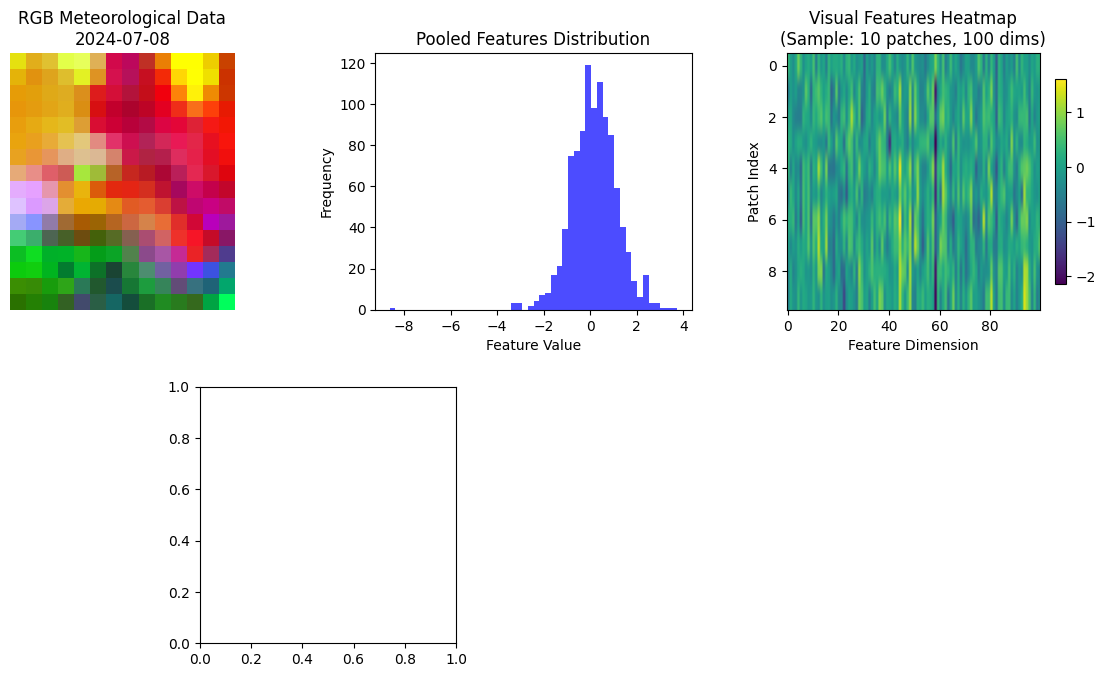

In [ ]:
# From pooler_viewer.py
import numpy as np
import matplotlib.pyplot as plt

def analyze_extracted_features(date_str=TEST_DATE):
    """
    Comprehensive analysis of extracted features
    """
    try:
        # Load combined features
        data = np.load(f"{test_folder}/combined_features/{date_str}_all_features.npy", allow_pickle=True).item()
        
        print(f"=== Feature Analysis for {date_str} ===\n")
        
        # 1. CLIP Features Analysis
        print("1. CLIP Visual Features:")
        pooled = data['pooled_features']
        print(f"   Pooled features shape: {pooled.shape}")
        print(f"   Pooled features range: [{pooled.min():.3f}, {pooled.max():.3f}]")
        print(f"   Pooled features mean: {pooled.mean():.3f}")
        
        visual = data['visual_features']
        print(f"   Visual features shape: {visual.shape}")
        print(f"   Visual features range: [{visual.min():.3f}, {visual.max():.3f}]")
        
        # 2. Physical Features Analysis
        if data['physical_features']:
            print("\n2. Physical Climate Features:")
            physical = data['physical_features']
            for key, value in physical.items():
                if isinstance(value, (int, float)):
                    print(f"   {key}: {value}")
        
        # 3. Create comprehensive visualization
        create_feature_analysis_plot(data, date_str)
        
        return data
        
    except Exception as e:
        print(f"Error analyzing features: {e}")
        return None

def create_feature_analysis_plot(data, date_str):
    """
    Create comprehensive feature analysis visualization
    """
    fig = plt.figure(figsize=(20, 12))
    
    # Create layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Original RGB image
    try:
        rgb_path = f"{test_folder}/rgb_images/rgb_image_{date_str}.png"
        if os.path.exists(rgb_path):
            from PIL import Image
            rgb_img = Image.open(rgb_path)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.imshow(rgb_img)
            ax1.set_title(f'RGB Meteorological Data\n{date_str}')
            ax1.axis('off')
    except:
        pass
    
    # 2. Pooled features distribution
    ax2 = fig.add_subplot(gs[0, 1])
    pooled = data['pooled_features']
    ax2.hist(pooled, bins=50, alpha=0.7, color='blue')
    ax2.set_title('Pooled Features Distribution')
    ax2.set_xlabel('Feature Value')
    ax2.set_ylabel('Frequency')
    
    # 3. Visual features heatmap (first 100 features)
    ax3 = fig.add_subplot(gs[0, 2])
    visual_sample = data['visual_features'][:10, :100]  # Sample for visualization
    im3 = ax3.imshow(visual_sample, cmap='viridis', aspect='auto')
    ax3.set_title('Visual Features Heatmap\n(Sample: 10 patches, 100 dims)')
    ax3.set_xlabel('Feature Dimension')
    ax3.set_ylabel('Patch Index')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    # 5. Feature correlation analysis
    ax5 = fig.add_subplot(gs[1, :2])
    # Compute correlation between pooled features
    pooled_reshaped = pooled.reshape(-1, 1)
    correlation_matrix = np.corrcoef(pooled[:100])  # Sample for visualization
    im5 = ax5.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax5.set_title('Feature Correlation Matrix (Sample)')
    plt.colorbar(im5, ax=ax5, shrink=0.8)
    
    # 6. Principal components visualization
    ax6 = fig.add_subplot(gs[1, 2:])
    from sklearn.decomposition import PCA
    pca = PCA(n_components=10)
    pca_features = pca.fit_transform(data['visual_features'])
    
    # Plot explained variance
    ax6.bar(range(1, 11), pca.explained_variance_ratio_, color='purple', alpha=0.7)
    ax6.set_title('PCA Explained Variance Ratio')
    ax6.set_xlabel('Principal Component')
    ax6.set_ylabel('Explained Variance Ratio')
    
    # 7. Feature statistics summary
    ax7 = fig.add_subplot(gs[2, :])
    stats_text = f"""
Feature Statistics Summary for {date_str}:

CLIP Features:
• Pooled features: {pooled.shape} - Global image representation
• Visual features: {data['visual_features'].shape} - Patch-level features  
• Range: [{pooled.min():.3f}, {pooled.max():.3f}], Mean: {pooled.mean():.3f}

Physical Features:
"""
    if data['physical_features']:
        for key, value in numeric_features.items():
            stats_text += f"• {key}: {value}\n"
    
    ax7.text(0.05, 0.5, stats_text, fontsize=10, verticalalignment='center',
             transform=ax7.transAxes, fontfamily='monospace')
    ax7.axis('off')
    
    plt.suptitle(f'Comprehensive Feature Analysis - {date_str}', fontsize=16)
    
    # Save analysis plot
    os.makedirs(f'{test_folder}/feature_analysis', exist_ok=True)
    plt.savefig(f'{test_folder}/feature_analysis/{date_str}_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Comprehensive analysis plot saved for {date_str}")

# Run feature analysis
analysis_results = analyze_extracted_features(TEST_DATE)

---

## 5. Complete Working Example {#complete-example}

### 5.1 End-to-End Pipeline Demonstration

In [ ]:
class CLLMateDemo:
    """
    Complete demonstration of current capabilities
    """
    
    def __init__(self):
        self.test_folder = TEST_FOLDER
        self.visual_encoder = CLLMateVisualEncoder(self.test_folder)
        self.feature_detector = CLLMateFeatureDetector(self.test_folder)
        
    def run_complete_pipeline(self, date_str=TEST_DATE):
        """
        Run complete pipeline with current implementations
        """
        
        print(f"Running CLLMate Pipeline for {date_str}")
        print("="*60)
        
        results = {}
        
        # Step 1: Data Processing
        print("\n1️⃣ Data Processing...")
        try:
            # Generate RGB image if not exists
            rgb_path = f"{self.test_folder}/rgb_images/rgb_image_{date_str}.png"
            if not os.path.exists(rgb_path):
                self.generate_rgb_for_date(date_str)
            
            # Get meteorological statistics
            stats = generate_meteorological_context(date_str)
            results['meteorological_stats'] = stats
            print("   ✅ RGB image generated")
            print("   ✅ Meteorological statistics computed")
            
        except Exception as e:
            print(f"   ❌ Error in data processing: {e}")
            return None
        
        # Step 2: Visual Feature Extraction
        print("\n2️⃣ Visual Feature Extraction...")
        try:
            visual_features = self.visual_encoder.extract_features(date_str)
            results['visual_features'] = visual_features
            print("   ✅ CLIP features extracted")
            print(f"   ✅ Pooled features: {visual_features['pooled_features'].shape}")
            print(f"   ✅ Visual features: {visual_features['visual_features'].shape}")
            
        except Exception as e:
            print(f"   ❌ Error in visual feature extraction: {e}")
            return None
        
        # Step 3: Enhanced Pattern Detection
        print("\n3️⃣ Enhanced Pattern Detection...")
        try:
            physical_features = enhanced_climate_processor(date_str)
            results['physical_features'] = physical_features
            
            if physical_features:
                print("   ✅ SCAFET shape index calculated")
                print(f"   ✅ Atmospheric rivers detected: {physical_features['atmospheric_rivers']}")
                print(f"   ✅ Cyclones detected: {physical_features['cyclones']}")
                print(f"   ✅ Front activity: {physical_features['fronts']} pixels")
            
        except Exception as e:
            print(f"   ❌ Error in pattern detection: {e}")
            physical_features = None
        
        # Step 4: Event Prediction (Rule-based for now)
        print("\n4️⃣ Climate Event Prediction...")
        try:
            predicted_events = self.predict_events_rule_based(stats, physical_features)
            results['predicted_events'] = predicted_events
            
            print("   ✅ Rule-based event prediction completed")
            print(f"   ✅ Predicted events: {len(predicted_events)}")
            for event in predicted_events[:5]:  # Show first 5
                print(f"      • {event}")
            if len(predicted_events) > 5:
                print(f"      ... and {len(predicted_events)-5} more")
                
        except Exception as e:
            print(f"   ❌ Error in event prediction: {e}")
            predicted_events = []
        
        # Step 5: CLLMate-style Instruction Generation
        print("\n5️⃣ Instruction Generation...")
        try:
            instruction = self.generate_cllmate_instruction(date_str, stats, predicted_events)
            results['instruction'] = instruction
            print("   ✅ CLLMate-style instruction generated")
            
        except Exception as e:
            print(f"   ❌ Error in instruction generation: {e}")
        
        # Step 6: Comprehensive Visualization
        print("\n6️⃣ Visualization Generation...")
        try:
            self.create_comprehensive_visualization(date_str, results)
            print("   ✅ Comprehensive visualization created")
            
        except Exception as e:
            print(f"   ❌ Error in visualization: {e}")
        
        print(f"\n🎉 Pipeline completed for {date_str}!")
        print("="*60)
        
        return results
    
    def generate_rgb_for_date(self, date_str):
        """Generate RGB image for specific date"""
        date_np = np.datetime64(date_str)
        
        temp_data = temp_ds[temp_var].sel(time=date_np, method="nearest")
        precip_data = precip_ds[precip_var].sel(time=date_np, method="nearest")
        wind_data = wind_ds[wind_var].sel(time=date_np, method="nearest")
        
        R = normalize(temp_data)
        G = normalize(wind_data)
        B = normalize(precip_data)
        
        rgb_image = np.stack([R, G, B], axis=-1)
        img = Image.fromarray(rgb_image)
        
        os.makedirs(f"{self.test_folder}/rgb_images", exist_ok=True)
        img.save(f"{self.test_folder}/rgb_images/rgb_image_{date_str}.png")
    
    def predict_events_rule_based(self, stats, physical_features):
        """
        Rule-based event prediction (placeholder for actual LLM)
        """
        events = []
        
        # Temperature-based events
        if stats['max_temp'] > 303:  # >30°C
            events.extend(['high_temperature', 'heat_wave_risk'])
            if stats['mean_precip'] < 0.1:
                events.extend(['drought_conditions', 'water_shortage_risk'])
        
        if stats['min_temp'] < 273:  # <0°C
            events.extend(['cold_air_mass', 'frost_risk', 'freezing_conditions'])
        
        # Precipitation-based events
        if stats['max_precip'] > 3.0:
            events.extend(['heavy_rainfall', 'flooding_risk'])
            if stats['mean_wind'] > 5.0:
                events.extend(['storm_conditions', 'severe_weather'])
        
        # Wind-based events
        if stats['max_wind'] > 10.0:
            events.extend(['strong_winds', 'wind_damage_risk'])
        
        # Physical pattern-based events
        if physical_features:
            if physical_features['atmospheric_rivers'] > 0:
                events.extend(['atmospheric_river', 'moisture_transport', 'enhanced_precipitation'])
            if physical_features['cyclones'] > 0:
                events.extend(['cyclonic_activity', 'low_pressure_system', 'weather_disturbance'])
            if physical_features['fronts'] > 100:
                events.extend(['temperature_front', 'weather_boundary', 'frontal_system'])
        
        # Secondary effects
        if 'flooding_risk' in events:
            events.extend(['traffic_disruption', 'urban_flooding', 'drainage_issues'])
        if 'heat_wave_risk' in events:
            events.extend(['health_advisory', 'energy_demand_spike', 'agricultural_stress'])
        if 'storm_conditions' in events:
            events.extend(['power_outage_risk', 'transportation_delays', 'structural_damage_risk'])
        
        return list(set(events))  # Remove duplicates
    
    def create_comprehensive_visualization(self, date_str, results):
        """
        Create visualization with 4 key components
        """
        fig = plt.figure(figsize=(24, 6))
        gs = fig.add_gridspec(1, 4, hspace=0.3, wspace=0.3)
        
        # 1. Original RGB meteorological data
        try:
            rgb_img = Image.open(f"{self.test_folder}/rgb_images/rgb_image_{date_str}.png")
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.imshow(rgb_img)
            ax1.set_title(f'RGB Meteorological Data\n{date_str}')
            ax1.axis('off')
        except Exception as e:
            print(f"Could not load RGB image: {e}")

        # 2. Enhanced weather patterns
        try:
            enhanced_img_path = f"{self.test_folder}/enhanced_features/{date_str}_enhanced_features.png"
            if os.path.exists(enhanced_img_path):
                enhanced_img = Image.open(enhanced_img_path)
                ax2 = fig.add_subplot(gs[0, 1])
                ax2.imshow(enhanced_img)
                ax2.set_title('Enhanced Weather Patterns')
                ax2.axis('off')
        except Exception as e:
            print(f"Could not load enhanced patterns: {e}")
        
        # 3. Coordinate map
        try:
            coord_map_path = f"{self.test_folder}/coordinate_maps/{date_str}_coverage_map.png"
            if os.path.exists(coord_map_path):
                coord_img = Image.open(coord_map_path)
                ax3 = fig.add_subplot(gs[0, 2])
                ax3.imshow(coord_img)
                ax3.set_title('Geographic Coverage Area')
                ax3.axis('off')
        except Exception as e:
            print(f"Could not load coordinate map: {e}")
        
        # 4. Feature statistics
        ax4 = fig.add_subplot(gs[0, 3])
        stats = results['meteorological_stats']
        stats_text = f"""Meteorological Statistics:

    Temperature (K):
    Max: {stats['max_temp']:.1f}
    Min: {stats['min_temp']:.1f}
    Mean: {stats['mean_temp']:.1f}

    Wind Speed (m/s):
    Max: {stats['max_wind']:.1f}
    Min: {stats['min_wind']:.1f}
    Mean: {stats['mean_wind']:.1f}

    Precipitation (mm):
    Max: {stats['max_precip']:.2f}
    Min: {stats['min_precip']:.2f}
    Mean: {stats['mean_precip']:.2f}"""
        
        ax4.text(0.05, 0.95, stats_text, fontsize=10, verticalalignment='top',
                transform=ax4.transAxes, fontfamily='monospace')
        ax4.axis('off')
        ax4.set_title('Climate Statistics')
        
        plt.suptitle(f'CLLMate Pipeline Results - {date_str}', fontsize=16, y=1.02)
        
        # Save comprehensive visualization
        os.makedirs(f'{self.test_folder}/pipeline_results', exist_ok=True)
        plt.savefig(f'{self.test_folder}/pipeline_results/{date_str}_complete_pipeline.png', 
                    dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"   Comprehensive visualization saved: {self.test_folder}/pipeline_results/{date_str}_complete_pipeline.png")
    
# Run complete demonstration
demo = CLLMateDemo()
demo_results = demo.run_complete_pipeline(TEST_DATE)